# Multilinear Interpolation Comparison

### Imports

In [27]:
%pip install interpolation
%pip install numba==0.59.1

import timeit
from typing import Sequence

from matplotlib import pyplot as plt
import numpy as np
import scipy
import interpolation

import pymedphys



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
def interp3d_econforge(axes, values, points_interp):
    grid = interpolation.splines.CGrid(*axes)
    return interpolation.splines.eval_linear(grid, values, points_interp)


In [29]:
def interp3d_scipy(axes, values, points_interp):
    interpolator = scipy.interpolate.RegularGridInterpolator(axes, values)
    return interpolator(points_interp)


In [30]:
def interp3d_pymedphys_skip_checks(axes, values, points_interp):
    return pymedphys.interpolate.interp(
        axes, values, points_interp=points_interp, skip_checks=True
    )


In [31]:
implementations = {
    "PyMedPhys default": pymedphys.interpolate.interp,
    "PyMedPhys skip checks": interp3d_pymedphys_skip_checks,
    "PyMedPhys low-level API": pymedphys.interp_linear_3d,
    "EconForge": interp3d_econforge,
    "Scipy": interp3d_scipy,
}


def benchmark(
    n_values: Sequence[int],
    interpolation_multiples: Sequence[int],
    fixed_n: int,
    fixed_multiple: int,
    implementations: dict,
):
    results = {
        "Performance with varying N": {
            "N values": n_values,
            "times": {name: [] for name in implementations.keys()},
            "fixed multiple": fixed_multiple,
        },
        "Performance with varying interpolation multiple": {
            "interpolation multiples": interpolation_multiples,
            "times": {name: [] for name in implementations.keys()},
            "fixed n": fixed_n,
        },
    }

    for n in n_values:
        run_combo(
            n, fixed_multiple, implementations, results["Performance with varying N"]
        )

    for multiple in interpolation_multiples:
        run_combo(
            fixed_n,
            multiple,
            implementations,
            results["Performance with varying interpolation multiple"],
        )

    return results


def run_combo(n, multiple, implementations, result):
    x = y = z = np.linspace(0, 1, n, dtype=np.float64)
    values = np.random.rand(n, n, n)

    xi = yi = zi = np.linspace(0, 1, n * multiple)
    points = np.column_stack(
        [mgrid.ravel() for mgrid in np.meshgrid(xi, yi, zi, indexing="ij")]
    )

    for name, f_interp in implementations.items():
        time = (
            timeit.timeit(
                lambda: f_interp(tuple((x, y, z)), values, points_interp=points),
                number=3,
            )
            / 3
        )
        result["times"][name].append(time)


In [32]:
def plot_results(results):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Performance vs n for fixed multiple
    for name, times in results["Performance with varying N"]["times"].items():
        ax1.plot(
            np.array(results["Performance with varying N"]["N values"], dtype=np.int32)
            ** 3,
            np.array(times),
            label=name,
            marker="o",
        )

    ax1.set_xlabel("Number of known points (N)")
    ax1.set_ylabel("Time (seconds)")
    ax1.set_title(
        f"Performance vs. Number of Known Points (multiple={results['Performance with varying N']['fixed multiple']})"
    )
    ax1.legend()
    ax1.set_xscale("log")
    ax1.set_yscale("log")

    # Left plot: Performance vs n for fixed multiple
    for name, times in results["Performance with varying interpolation multiple"][
        "times"
    ].items():
        ax2.plot(
            np.array(
                results["Performance with varying interpolation multiple"][
                    "interpolation multiples"
                ],
                dtype=np.int32,
            ),
            np.array(times),
            label=name,
            marker="o",
        )

    ax2.set_xlabel("Interpolation Multiple")
    ax2.set_ylabel("Time (seconds)")
    ax2.set_title(
        f"Performance vs. Interpolation Multiple (n={results['Performance with varying interpolation multiple']['fixed n']**3:,})"
    )
    ax2.legend()
    plt.xticks(
        results["Performance with varying interpolation multiple"][
            "interpolation multiples"
        ]
    )
    ax2.set_yscale("log")

    plt.tight_layout()
    plt.show()


In [33]:
# Run the benchmark
n_values = [10, 30, 100, 150]
interpolation_multiples = [2, 3, 4]
results = benchmark(
    n_values,
    interpolation_multiples,
    fixed_n=100,
    fixed_multiple=3,
    implementations=implementations,
)


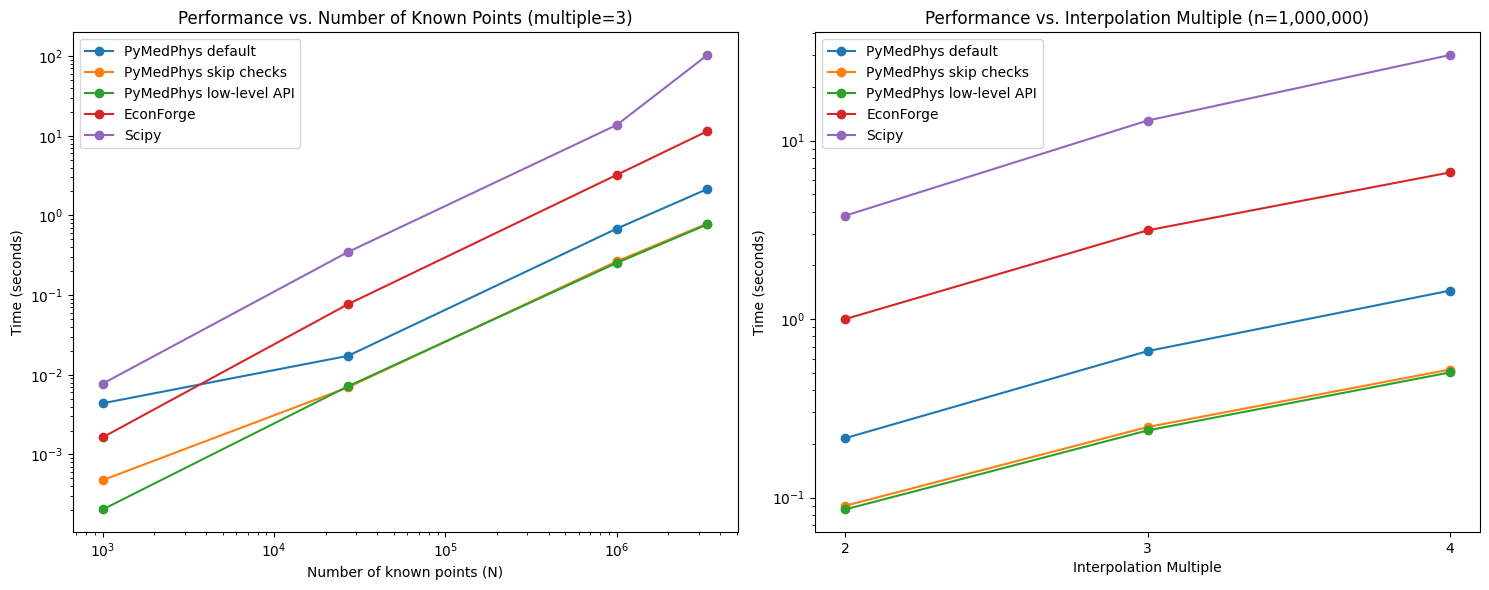

In [34]:
# Plot the results
plot_results(results)
